In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/CT-GAN-mini

!pwd

!pip install pydicom

Mounted at /content/drive
/content/drive/MyDrive/CT-GAN-mini
/content/drive/MyDrive/CT-GAN-mini
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pydicom
from skimage.transform import resize

# For mixed-precision training
from torch.amp import GradScaler, autocast

# Import itertools for optimizer
import itertools

# Other necessary imports
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

In [ ]:
# Training hyperparameters
n_epochs = 50
batch_size = 4  # Reduced batch size to minimize memory usage
lr = 0.0002
b1 = 0.5  # Adam optimizer hyperparameter
b2 = 0.999  # Adam optimizer hyperparameter
img_size = 256  # Keeping original image size
ct_slices = 128  # Keeping original number of CT slices
channels = 1  # Number of image channels (grayscale)

# Update CycleGAN hyperparameters
lambda_cyc = 10.0  # Cycle consistency loss weight
lambda_id = 0.0    # Identity loss weight (set to 0 because input dimensions differ)

In [ ]:
# Dataset class (unchanged)
class XrayCTDataset(Dataset):
    def __init__(self, root_dirs):
        self.patient_dirs = []
        for root_dir in root_dirs:
            patients = sorted(os.listdir(root_dir))
            patients = [p for p in patients if os.path.isdir(os.path.join(root_dir, p))]
            self.patient_dirs.extend([os.path.join(root_dir, p) for p in patients])

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]

        # Load and preprocess X-ray image
        xray_path = glob(os.path.join(patient_dir, 'Xray', '*'))[0]
        xray = self.load_and_preprocess_image(xray_path)

        # Load and preprocess CT slices
        ct_dir = os.path.join(patient_dir, 'CT')
        ct_slice_paths = sorted(glob(os.path.join(ct_dir, '*')))
        ct_slices_array = self.load_and_preprocess_ct_slices(ct_slice_paths)

        sample = {'xray': xray, 'ct': ct_slices_array}

        return sample

    def load_and_preprocess_image(self, image_path):
        # Check if the image is DICOM or PNG
        if image_path.endswith('.dcm'):
            # Load DICOM image
            ds = pydicom.dcmread(image_path)
            image = ds.pixel_array.astype(np.float32)
        else:
            # Load PNG image
            from PIL import Image
            image = Image.open(image_path).convert('L')
            image = np.array(image).astype(np.float32)

        # Normalize the image
        image = (image - image.min()) / (image.max() - image.min())

        # Resize the image
        image = resize(image, (img_size, img_size), mode='constant', anti_aliasing=True)

        # Convert to tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        return image

    def load_and_preprocess_ct_slices(self, slice_paths):
        num_slices = len(slice_paths)
        desired_slices = ct_slices

        # Calculate indices to select slices for alignment
        indices = np.linspace(0, num_slices - 1, desired_slices).astype(int)

        # Preallocate a list for the CT slices
        ct_slices_list = []
        for idx in indices:
            p = slice_paths[idx]
            # Load and preprocess each slice
            slice_ = self.load_and_preprocess_image(p)
            ct_slices_list.append(slice_)

        # Stack slices into a 3D volume
        ct_slices_array = torch.stack(ct_slices_list, dim=0)  # Shape: [ct_slices, 1, img_size, img_size]
        ct_slices_array = ct_slices_array.squeeze(1)  # Shape: [ct_slices, img_size, img_size]
        ct_slices_array = ct_slices_array.unsqueeze(0)  # Shape: [1, ct_slices, img_size, img_size]

        return ct_slices_array  # Return shape: [1, ct_slices, img_size, img_size]

In [ ]:
# Paths to the datasets
original_dataset_root = 'LIDC-IDRI/'
generated_dataset_root = 'CycleGAN_Generated_LIDC-IDRI/'

# Create dataset and dataloader
dataset = XrayCTDataset(root_dirs=[original_dataset_root])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
# Define the Generator G: X-ray to CT (unchanged)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder: From [B, 1, 256, 256] to [B, 256, 16, 16]
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4, stride=2, padding=1),   # [B, 32, 128, 128]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),         # [B, 64, 64, 64]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),        # [B, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),       # [B, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Bridge between encoder and decoder
        self.bridge = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),       # [B, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Decoder: Upsamples the features and depth dimension
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=(4,4,4), stride=(2,2,2), padding=(1,1,1)),  # [B, 128, 2, 32, 32]
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose3d(128, 64, kernel_size=(4,4,4), stride=(2,2,2), padding=(1,1,1)),   # [B, 64, 4, 64, 64]
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose3d(64, 32, kernel_size=(4,4,4), stride=(2,2,2), padding=(1,1,1)),    # [B, 32, 8, 128, 128]
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose3d(32, channels, kernel_size=(4,4,4), stride=(2,2,2), padding=(1,1,1)),  # [B, 1, 16, 256, 256]
            nn.Tanh(),
        )

        # Adjust the depth dimension to ct_slices
        # Upsample depth from 16 to ct_slices (128)
        self.depth_adjust = nn.ConvTranspose3d(
            channels, channels, kernel_size=(ct_slices // 16, 1, 1), stride=(ct_slices // 16, 1, 1)
        )

    def forward(self, x):
        x = self.encoder(x)                   # [B, 256, 16, 16]
        x = self.bridge(x)                    # [B, 256, 16, 16]
        x = x.unsqueeze(2)                    # [B, 256, 1, 16, 16]

        # Decoder: Upsample both spatial dimensions and depth
        x = self.decoder(x)                   # [B, 1, 16, 256, 256]
        x = self.depth_adjust(x)              # Upsample depth to ct_slices (128)
        return x

class Generator3Dto2D(nn.Module):
    def __init__(self):
        super(Generator3Dto2D, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Bridge
        self.bridge = nn.Sequential(
            nn.Conv3d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
        )

        # Depth reduction and decoder
        self.depth_reduce = nn.Conv3d(256, 256, kernel_size=(ct_slices // 16, 1, 1))
        self.decoder = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)        # [B, 256, D/16, H/16, W/16]
        x = self.bridge(x)         # [B, 256, D/16, H/16, W/16]
        x = self.depth_reduce(x)   # [B, 256, 1, H/16, W/16]
        x = x.squeeze(2)           # [B, 256, H/16, W/16]
        x = self.decoder(x)        # [B, 1, H, W]
        return x

# Define Discriminator D_Y: for CT volumes (unchanged)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv3d(channels, 32, kernel_size=4, stride=2, padding=1),    # [B, 32, D/2, 128, 128]
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1),          # [B, 64, D/4, 64, 64]
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),         # [B, 128, D/8, 32, 32]
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),        # [B, 256, D/16, 16, 16]
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Output layers
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))                         # [B, 256, 1, 1, 1]
        self.adv_layer = nn.Sequential(
            nn.Flatten(),                                                   # [B, 256]
            nn.Linear(256, 1),                                              # [B, 1]
            # nn.Sigmoid(),  # Removed because we use MSELoss
        )

    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        validity = self.adv_layer(x)
        return validity

# Define Discriminator D_X: for X-ray images
class Discriminator2D(nn.Module):
    def __init__(self):
        super(Discriminator2D, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4, stride=2, padding=1),   # [B, 32, H/2, W/2]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),         # [B, 64, H/4, W/4]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),        # [B, 128, H/8, W/8]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),       # [B, 256, H/16, W/16]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))                          # [B, 256, 1, 1]
        self.adv_layer = nn.Sequential(
            nn.Flatten(),                                                 # [B, 256]
            nn.Linear(256, 1),                                            # [B, 1]
            # nn.Sigmoid(),  # Removed because we use MSELoss
        )

    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        validity = self.adv_layer(x)
        return validity

In [ ]:
# Function to count parameters (unchanged)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize generators and discriminators
G = Generator()
F = Generator3Dto2D()

D_Y = Discriminator()
D_X = Discriminator2D()

# Print the number of parameters
print(f"G parameters: {count_parameters(G)}")
print(f"F parameters: {count_parameters(F)}")
print(f"D_Y parameters: {count_parameters(D_Y)}")
print(f"D_X parameters: {count_parameters(D_X)}")

G parameters: 4035914
F parameters: 5740609
D_Y parameters: 2756257
D_X parameters: 690337


In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.to(device)
F.to(device)
D_Y.to(device)
D_X.to(device)

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(itertools.chain(G.parameters(), F.parameters()), lr=lr, betas=(b1, b2))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=lr, betas=(b1, b2))

# For mixed-precision training
scaler = GradScaler()

In [ ]:
# Training loop
for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_x = batch['xray'].to(device, non_blocking=True)  # Shape: [B, 1, H, W]
        real_y = batch['ct'].to(device, non_blocking=True)    # Shape: [B, 1, D, H, W]

        # Adversarial ground truths
        valid = torch.ones((real_x.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((real_x.size(0), 1), requires_grad=False).to(device)

        # ----------------------
        #  Train Generators
        # ----------------------
        optimizer_G.zero_grad()

        with autocast(device_type='cuda'):
            # Identity loss
            if lambda_id > 0:
                # Identity loss is not applicable here due to input dimension mismatch
                loss_id_y = 0
                loss_id_x = 0
            else:
                loss_id_y = 0
                loss_id_x = 0

            # GAN loss
            fake_y = G(real_x)
            pred_fake_y = D_Y(fake_y)
            loss_GAN_G = criterion_GAN(pred_fake_y, valid)

            fake_x = F(real_y)
            pred_fake_x = D_X(fake_x)
            loss_GAN_F = criterion_GAN(pred_fake_x, valid)

            # Cycle consistency loss
            recov_x = F(fake_y)
            loss_cycle_x = criterion_cycle(recov_x, real_x) * lambda_cyc

            recov_y = G(fake_x)
            loss_cycle_y = criterion_cycle(recov_y, real_y) * lambda_cyc

            # Total loss
            loss_G = loss_GAN_G + loss_GAN_F + loss_cycle_x + loss_cycle_y + loss_id_y + loss_id_x

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # -----------------------
        #  Train Discriminator Y
        # -----------------------
        optimizer_D_Y.zero_grad()

        with autocast(device_type='cuda'):
            # Real loss
            pred_real = D_Y(real_y)
            loss_D_real = criterion_GAN(pred_real, valid)

            # Fake loss
            pred_fake = D_Y(fake_y.detach())
            loss_D_fake = criterion_GAN(pred_fake, fake)

            # Total loss
            loss_D_Y = 0.5 * (loss_D_real + loss_D_fake)

        scaler.scale(loss_D_Y).backward()
        scaler.step(optimizer_D_Y)
        scaler.update()

        # -----------------------
        #  Train Discriminator X
        # -----------------------
        optimizer_D_X.zero_grad()

        with autocast(device_type='cuda'):
            # Real loss
            pred_real = D_X(real_x)
            loss_D_real = criterion_GAN(pred_real, valid)

            # Fake loss
            pred_fake = D_X(fake_x.detach())
            loss_D_fake = criterion_GAN(pred_fake, fake)

            # Total loss
            loss_D_X = 0.5 * (loss_D_real + loss_D_fake)

        scaler.scale(loss_D_X).backward()
        scaler.step(optimizer_D_X)
        scaler.update()

        # Print training progress
        print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {i+1}/{len(dataloader)}] "
              f"[D_X loss: {loss_D_X.item():.4f}] [D_Y loss: {loss_D_Y.item():.4f}] "
              f"[G loss: {loss_G.item():.4f}]")

[Epoch 1/50] [Batch 1/48] [D_X loss: 0.4633] [D_Y loss: 0.3225] [G loss: 11.3210]
[Epoch 1/50] [Batch 2/48] [D_X loss: 0.4089] [D_Y loss: 0.3050] [G loss: 10.7784]
[Epoch 1/50] [Batch 3/48] [D_X loss: 0.3843] [D_Y loss: 0.6881] [G loss: 10.2813]
[Epoch 1/50] [Batch 4/48] [D_X loss: 0.3191] [D_Y loss: 0.3269] [G loss: 10.8095]
[Epoch 1/50] [Batch 5/48] [D_X loss: 0.3219] [D_Y loss: 0.2667] [G loss: 9.7446]
[Epoch 1/50] [Batch 6/48] [D_X loss: 0.2451] [D_Y loss: 0.2835] [G loss: 8.5454]
[Epoch 1/50] [Batch 7/48] [D_X loss: 0.2094] [D_Y loss: 0.1835] [G loss: 8.3726]
[Epoch 1/50] [Batch 8/48] [D_X loss: 0.2826] [D_Y loss: 0.2047] [G loss: 6.5648]
[Epoch 1/50] [Batch 9/48] [D_X loss: 0.4734] [D_Y loss: 0.2204] [G loss: 6.7160]
[Epoch 1/50] [Batch 10/48] [D_X loss: 0.2725] [D_Y loss: 0.3398] [G loss: 6.0527]
[Epoch 1/50] [Batch 11/48] [D_X loss: 0.2319] [D_Y loss: 0.2093] [G loss: 4.9131]
[Epoch 1/50] [Batch 12/48] [D_X loss: 0.2326] [D_Y loss: 0.4220] [G loss: 6.2609]
[Epoch 1/50] [Batch 1

In [ ]:
def visualize_results(generator, dataloader, device):
    generator.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            xray = batch['xray'].to(device, non_blocking=True)
            ct_real = batch['ct'].to(device, non_blocking=True)

            # Generate CT scans
            gen_ct = generator(xray)

            # Select the first sample from the batch
            xray_np = xray[0].squeeze().cpu().numpy()        # Shape: [img_size, img_size]
            ct_real_np = ct_real[0].squeeze().cpu().numpy()  # Shape: [ct_slices, img_size, img_size]
            gen_ct_np = gen_ct[0].squeeze().cpu().numpy()    # Shape: [ct_slices, img_size, img_size]

            # Print shapes for debugging
            print(f"xray_np.shape: {xray_np.shape}")
            print(f"ct_real_np.shape: {ct_real_np.shape}")
            print(f"gen_ct_np.shape: {gen_ct_np.shape}")

            # Select a slice to visualize (e.g., middle slice)
            slice_idx = ct_slices // 2
            ct_real_slice = ct_real_np[slice_idx]
            gen_ct_slice = gen_ct_np[slice_idx]

            # Calculate PSNR and SSIM for the selected slice
            psnr_value = psnr(ct_real_slice, gen_ct_slice, data_range=gen_ct_slice.max() - gen_ct_slice.min())
            ssim_value = ssim(ct_real_slice, gen_ct_slice, data_range=gen_ct_slice.max() - gen_ct_slice.min())

            # Plot X-ray, real CT slice, and generated CT slice
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(xray_np, cmap='gray')
            axs[0].set_title('Input X-ray')
            axs[0].axis('off')

            axs[1].imshow(ct_real_slice, cmap='gray')
            axs[1].set_title('Real CT Slice')
            axs[1].axis('off')

            axs[2].imshow(gen_ct_slice, cmap='gray')
            axs[2].set_title(f'Generated CT Slice\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}')
            axs[2].axis('off')

            plt.show()

            # Visualize only one sample
            break

In [ ]:
def calculate_metrics(generator, dataloader, device):
    generator.eval()
    mse_total = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    num_slices = 0

    with torch.no_grad():
        for batch in dataloader:
            xray = batch['xray'].to(device, non_blocking=True)
            ct_real = batch['ct'].to(device, non_blocking=True)

            # Generate CT scans
            gen_ct = generator(xray)

            # Convert to numpy arrays
            ct_real_np = ct_real.cpu().numpy()  # Shape: [batch_size, 1, ct_slices, img_size, img_size]
            gen_ct_np = gen_ct.cpu().numpy()    # Shape: [batch_size, 1, ct_slices, img_size, img_size]

            # Remove singleton channel dimension
            ct_real_np = np.squeeze(ct_real_np, axis=1)  # Shape: [batch_size, ct_slices, img_size, img_size]
            gen_ct_np = np.squeeze(gen_ct_np, axis=1)    # Shape: [batch_size, ct_slices, img_size, img_size]

            # Loop over batch and slices
            batch_size = ct_real_np.shape[0]

            for b in range(batch_size):
                for s in range(ct_slices):
                    real_slice = ct_real_np[b, s]
                    gen_slice = gen_ct_np[b, s]

                    mse = np.mean((real_slice - gen_slice) ** 2)
                    psnr_value = psnr(real_slice, gen_slice, data_range=gen_slice.max() - gen_slice.min())
                    ssim_value = ssim(real_slice, gen_slice, data_range=gen_slice.max() - gen_slice.min())

                    mse_total += mse
                    psnr_total += psnr_value
                    ssim_total += ssim_value
                    num_slices += 1

    # Average the metrics
    mse_avg = mse_total / num_slices
    psnr_avg = psnr_total / num_slices
    ssim_avg = ssim_total / num_slices

    print(f"Average MSE: {mse_avg:.4f}")
    print(f"Average PSNR: {psnr_avg:.2f} dB")
    print(f"Average SSIM: {ssim_avg:.4f}")

xray_np.shape: (256, 256)
ct_real_np.shape: (128, 256, 256)
gen_ct_np.shape: (128, 256, 256)


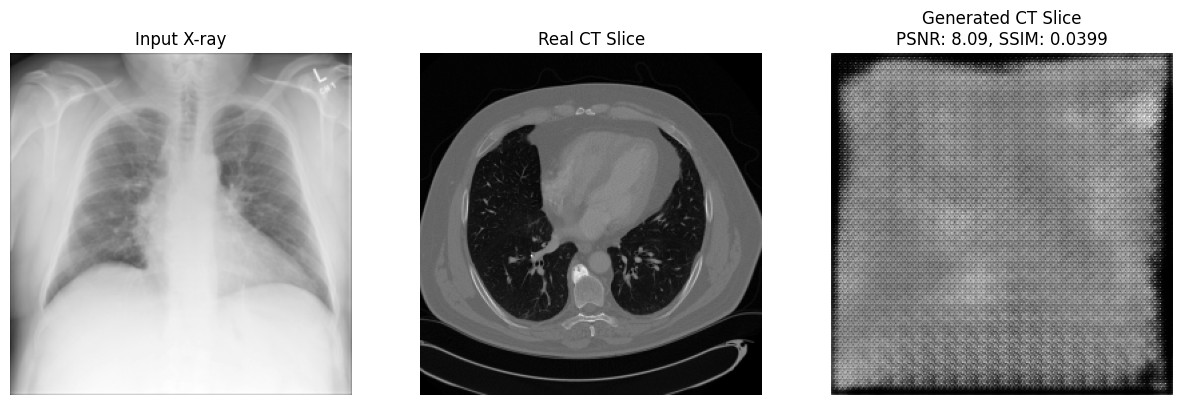

Average MSE: 0.0767
Average PSNR: 4.16 dB
Average SSIM: 0.0484


In [ ]:
# Visualize results using generator G
visualize_results(G, dataloader, device)

# Calculate metrics using generator G
calculate_metrics(G, dataloader, device)

In [ ]:
# Save the models and optimizers after the first training phase
torch.save({
    'epoch': n_epochs,
    'G_state_dict': G.state_dict(),
    'F_state_dict': F.state_dict(),
    'D_X_state_dict': D_X.state_dict(),
    'D_Y_state_dict': D_Y.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_X_state_dict': optimizer_D_X.state_dict(),
    'optimizer_D_Y_state_dict': optimizer_D_Y.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
}, 'cyclegan_model_checkpoint.pth')

# Semi-supervised

In [ ]:
import os
import torch
import numpy as np
from skimage.transform import resize
from PIL import Image
from tqdm import tqdm  # For progress bar

# Ensure the generator is in evaluation mode
G.eval()

# Path to the ChestX-ray14 dataset
chest_xray14_root = 'ChestX-ray14/'

# Directory to save the generated data
generated_data_root = 'CycleGAN_Generated_LIDC-IDRI/'

# Create the root directory if it doesn't exist
os.makedirs(generated_data_root, exist_ok=True)

# Get the list of X-ray images
xray_image_paths = [os.path.join(chest_xray14_root, fname)
                    for fname in os.listdir(chest_xray14_root) if fname.endswith('.png')]

# Function to load and preprocess ChestX-ray14 images
def load_and_preprocess_chest_xray(image_path):
    # Load the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = np.array(image).astype(np.float32)

    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min())

    # Resize the image
    image = resize(image, (img_size, img_size), mode='constant', anti_aliasing=True)

    # Convert to tensor and add channel dimension
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return image_tensor

# Iterate over the ChestX-ray14 images and generate CT slices
for idx, xray_image_path in tqdm(enumerate(xray_image_paths), total=len(xray_image_paths)):
    # Create a unique patient ID
    patient_id = f'ChestXray14_{idx+1:05d}'
    patient_dir = os.path.join(generated_data_root, patient_id)
    ct_dir = os.path.join(patient_dir, 'CT')
    xray_dir = os.path.join(patient_dir, 'Xray')
    os.makedirs(ct_dir, exist_ok=True)
    os.makedirs(xray_dir, exist_ok=True)

    # Load and preprocess the X-ray image
    xray_tensor = load_and_preprocess_chest_xray(xray_image_path).to(device)

    # Generate CT slices
    with torch.no_grad():
        gen_ct = G(xray_tensor)

    # Convert generated CT to numpy array
    gen_ct_np = gen_ct.squeeze().cpu().numpy()  # Shape: [ct_slices, img_size, img_size]

    # Save generated CT slices
    for i in range(ct_slices):
        slice_image = gen_ct_np[i]  # Shape: [img_size, img_size]
        # Normalize and convert to uint16
        slice_image = (slice_image - slice_image.min()) / (slice_image.max() - slice_image.min())
        slice_image_uint16 = (slice_image * 65535).astype(np.uint16)
        # Save as PNG
        slice_filename = os.path.join(ct_dir, f'slice_{i:03d}.png')
        Image.fromarray(slice_image_uint16).save(slice_filename)

    # Save the preprocessed X-ray image
    xray_np = xray_tensor.squeeze().cpu().numpy()  # Shape: [img_size, img_size]
    xray_uint16 = (xray_np * 65535).astype(np.uint16)
    xray_filename = os.path.join(xray_dir, 'xray.png')
    Image.fromarray(xray_uint16).save(xray_filename)

100%|██████████| 200/200 [04:51<00:00,  1.46s/it]


In [ ]:
# Paths to the datasets
original_dataset_root = 'LIDC-IDRI/'
generated_dataset_root = 'CycleGAN_Generated_LIDC-IDRI/'

# Create combined dataset and dataloader
combined_dataset = XrayCTDataset(root_dirs=[original_dataset_root, generated_dataset_root])
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Reinitialize the optimizers if necessary
optimizer_G = optim.Adam(itertools.chain(G.parameters(), F.parameters()), lr=lr, betas=(b1, b2))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=lr, betas=(b1, b2))

In [ ]:
# Load the checkpoint
checkpoint = torch.load('cyclegan_model_checkpoint.pth', map_location=device)

# Load state dictionaries
G.load_state_dict(checkpoint['G_state_dict'])
F.load_state_dict(checkpoint['F_state_dict'])
D_X.load_state_dict(checkpoint['D_X_state_dict'])
D_Y.load_state_dict(checkpoint['D_Y_state_dict'])

optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D_X.load_state_dict(checkpoint['optimizer_D_X_state_dict'])
optimizer_D_Y.load_state_dict(checkpoint['optimizer_D_Y_state_dict'])

scaler.load_state_dict(checkpoint['scaler_state_dict'])

# Set the starting epoch
start_epoch = checkpoint['epoch']

<ipython-input-35-9cb44142a285>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('cyclegan_model_checkpoint.pth', map_location=device)


In [ ]:
# Adjust n_epochs if you want to train for additional epochs
total_epochs = start_epoch + 20  # Train for 50 more epochs

for epoch in range(start_epoch, total_epochs):
    for i, batch in enumerate(combined_dataloader):
        # Set model input
        real_x = batch['xray'].to(device, non_blocking=True)  # Shape: [B, 1, H, W]
        real_y = batch['ct'].to(device, non_blocking=True)    # Shape: [B, 1, D, H, W]

        # Adversarial ground truths
        valid = torch.ones((real_x.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((real_x.size(0), 1), requires_grad=False).to(device)

        # ----------------------
        #  Train Generators
        # ----------------------
        optimizer_G.zero_grad()

        with autocast(device_type=device.type):
            # Identity loss
            loss_id_y = 0
            loss_id_x = 0

            # GAN loss
            fake_y = G(real_x)
            pred_fake_y = D_Y(fake_y)
            loss_GAN_G = criterion_GAN(pred_fake_y, valid)

            fake_x = F(real_y)
            pred_fake_x = D_X(fake_x)
            loss_GAN_F = criterion_GAN(pred_fake_x, valid)

            # Cycle consistency loss
            recov_x = F(fake_y)
            loss_cycle_x = criterion_cycle(recov_x, real_x) * lambda_cyc

            recov_y = G(fake_x)
            loss_cycle_y = criterion_cycle(recov_y, real_y) * lambda_cyc

            # Total loss
            loss_G = loss_GAN_G + loss_GAN_F + loss_cycle_x + loss_cycle_y + loss_id_y + loss_id_x

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # -----------------------
        #  Train Discriminator Y
        # -----------------------
        optimizer_D_Y.zero_grad()

        with autocast(device_type=device.type):
            # Real loss
            pred_real = D_Y(real_y)
            loss_D_real = criterion_GAN(pred_real, valid)

            # Fake loss
            pred_fake = D_Y(fake_y.detach())
            loss_D_fake = criterion_GAN(pred_fake, fake)

            # Total loss
            loss_D_Y = 0.5 * (loss_D_real + loss_D_fake)

        scaler.scale(loss_D_Y).backward()
        scaler.step(optimizer_D_Y)
        scaler.update()

        # -----------------------
        #  Train Discriminator X
        # -----------------------
        optimizer_D_X.zero_grad()

        with autocast(device_type=device.type):
            # Real loss
            pred_real = D_X(real_x)
            loss_D_real = criterion_GAN(pred_real, valid)

            # Fake loss
            pred_fake = D_X(fake_x.detach())
            loss_D_fake = criterion_GAN(pred_fake, fake)

            # Total loss
            loss_D_X = 0.5 * (loss_D_real + loss_D_fake)

        scaler.scale(loss_D_X).backward()
        scaler.step(optimizer_D_X)
        scaler.update()

        # Print training progress
        print(f"[Semi-supervised Training][Epoch {epoch+1}/{total_epochs}] [Batch {i+1}/{len(combined_dataloader)}] "
              f"[D_X loss: {loss_D_X.item():.4f}] [D_Y loss: {loss_D_Y.item():.4f}] "
              f"[G loss: {loss_G.item():.4f}]")

    # Save the checkpoint after each epoch
    torch.save({
        'epoch': epoch + 1,  # Save the next epoch number
        'G_state_dict': G.state_dict(),
        'F_state_dict': F.state_dict(),
        'D_X_state_dict': D_X.state_dict(),
        'D_Y_state_dict': D_Y.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_X_state_dict': optimizer_D_X.state_dict(),
        'optimizer_D_Y_state_dict': optimizer_D_Y.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
    }, 'semi_sup_cyclegan_model_checkpoint.pth')


[Semi-supervised Training][Epoch 51/70] [Batch 1/98] [D_X loss: 0.2136] [D_Y loss: 0.1992] [G loss: 6.5831]
[Semi-supervised Training][Epoch 51/70] [Batch 2/98] [D_X loss: 0.2478] [D_Y loss: 0.2265] [G loss: 6.4090]


<ipython-input-4-b9d891a46201>:42: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min())


[Semi-supervised Training][Epoch 51/70] [Batch 3/98] [D_X loss: nan] [D_Y loss: nan] [G loss: nan]
[Semi-supervised Training][Epoch 51/70] [Batch 4/98] [D_X loss: 0.2623] [D_Y loss: 0.1980] [G loss: 6.3828]
[Semi-supervised Training][Epoch 51/70] [Batch 5/98] [D_X loss: 0.2077] [D_Y loss: 0.1927] [G loss: 6.7269]
[Semi-supervised Training][Epoch 51/70] [Batch 6/98] [D_X loss: 0.1675] [D_Y loss: 0.1581] [G loss: 6.6094]
[Semi-supervised Training][Epoch 51/70] [Batch 7/98] [D_X loss: 0.1464] [D_Y loss: 0.2496] [G loss: 7.9828]
[Semi-supervised Training][Epoch 51/70] [Batch 8/98] [D_X loss: 0.0707] [D_Y loss: 0.1870] [G loss: 7.6102]
[Semi-supervised Training][Epoch 51/70] [Batch 9/98] [D_X loss: 0.1277] [D_Y loss: 0.1829] [G loss: 7.7971]
[Semi-supervised Training][Epoch 51/70] [Batch 10/98] [D_X loss: 0.1237] [D_Y loss: 0.1916] [G loss: 7.5981]
[Semi-supervised Training][Epoch 51/70] [Batch 11/98] [D_X loss: 0.0619] [D_Y loss: 0.2483] [G loss: 8.0962]
[Semi-supervised Training][Epoch 51

xray_np.shape: (256, 256)
ct_real_np.shape: (128, 256, 256)
gen_ct_np.shape: (128, 256, 256)


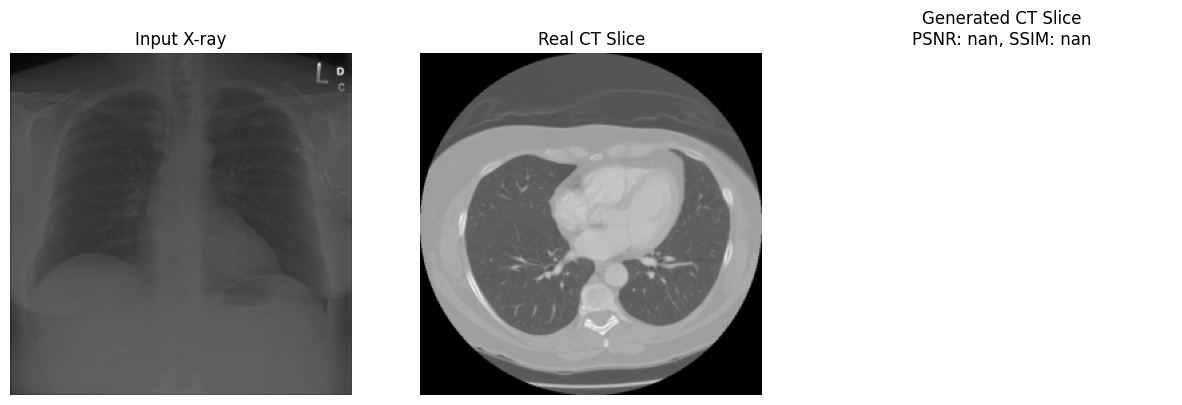

Average MSE: nan
Average PSNR: nan dB
Average SSIM: nan


In [ ]:
# Visualize results
visualize_results(G, dataloader, device)

# Calculate metrics
calculate_metrics(G, dataloader, device)